In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

std=StandardScaler()
# set up everything so that the figures show up in the notebook
init_notebook_mode(connected=True)

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tools.eval_measures import rmse, aic

filterwarnings('ignore')

# Indeed data modeling

## Load data

In [3]:
df_indeed = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/Indeed_SDEJobs_20200816_combined.csv')
df_indeed.head()

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City,Date in num
0,Full Stack Engineer,Triad Behavioral Health,Alabama,"Huntsville, AL",2 days ago,NaN,Technical assignment in our Slack channel - 5 ...,About Triad Behavioral HealthTriad Behavioral ...,AL,2020-08-14,Fri,Huntsville,NaN
1,Automation Controls Engineer,Tonya Michael,Alabama,"Troy, AL",2 days ago,NaN,Proven project management skills required to d...,Controls Engineer AT3 Staffing is partnered w...,AL,2020-08-14,Fri,Troy,NaN
2,Junior to Mid-Level Software Developer - GH WST,Dynetics,Alabama,"Huntsville, AL",2 days ago,NaN,The team follows Agile software development pr...,"Dynetics, a wholly owned subsidiary of Leidos,...",AL,2020-08-14,Fri,Huntsville,NaN
3,Technical Support Analyst (SQL),ProctorU,Alabama,"Birmingham, AL 35244",2 days ago,NaN,Experience with a scripting language (powershe...,"The Company: Headquartered in Birmingham, AL (...",AL,2020-08-14,Fri,Birmingham,NaN
4,Software Airworthiness Engineer,COLSA,Alabama,"Huntsville, AL 35806",2 days ago,NaN,Participate in government and/or developer inf...,General Summary Located at the US Army AMRDEC...,AL,2020-08-14,Fri,Huntsville,NaN


In [34]:
df_indeed

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City,Date in num
0,Full Stack Engineer,Triad Behavioral Health,Alabama,"Huntsville, AL",2 days ago,NaN,Technical assignment in our Slack channel - 5 ...,About Triad Behavioral HealthTriad Behavioral ...,AL,2020-08-14,Fri,Huntsville,NaN
1,Automation Controls Engineer,Tonya Michael,Alabama,"Troy, AL",2 days ago,NaN,Proven project management skills required to d...,Controls Engineer AT3 Staffing is partnered w...,AL,2020-08-14,Fri,Troy,NaN
2,Junior to Mid-Level Software Developer - GH WST,Dynetics,Alabama,"Huntsville, AL",2 days ago,NaN,The team follows Agile software development pr...,"Dynetics, a wholly owned subsidiary of Leidos,...",AL,2020-08-14,Fri,Huntsville,NaN
3,Technical Support Analyst (SQL),ProctorU,Alabama,"Birmingham, AL 35244",2 days ago,NaN,Experience with a scripting language (powershe...,"The Company: Headquartered in Birmingham, AL (...",AL,2020-08-14,Fri,Birmingham,NaN
4,Software Airworthiness Engineer,COLSA,Alabama,"Huntsville, AL 35806",2 days ago,NaN,Participate in government and/or developer inf...,General Summary Located at the US Army AMRDEC...,AL,2020-08-14,Fri,Huntsville,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61094,Python Web Developer,Nfinity LLC,Washington DC,"Washington, DC",29 days ago,"$120,000 - $140,000 a year",Must possess at least 5 years of web developer...,Senior Web Developer ********Must be a U.S. C...,DC,2020-06-13,Sat,Washington,29.0
61095,Senior DevOPs Engineer - AWS - Terraform,CEDENT,Washington DC,"Washington, DC",29 days ago,"$120,000 - $175,000 a year",Act as enablement expert for software engineer...,Title: Senior DevOPs Engineer - AWS - Terrafor...,DC,2020-06-13,Sat,Washington,29.0
61096,Software Engineer (SME),Leidos,Washington DC,"Washington, DC 20090 (South West area)",19 days ago,NaN,"Perform software systems development, includin...",Description Job Description: Leidos is seeking...,DC,2020-06-23,Tue,Washington,19.0
61097,"Principal Java/J2EE Software Engineer, ICAM/LD...",Northrop Grumman,Washington DC,"Fort Belvoir, VA",25 days ago,NaN,Participate in the agile software development ...,Are you interested in expanding your career th...,VA,2020-06-17,Wed,Fort Belvoir,25.0


In [4]:
bydate = df_indeed.groupby('Post date').size()

df_date_indeed = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_indeed['Date'], y=df_date_indeed['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist open positions vs. post date')
fig.show()

In [6]:
df_date_indeed['Date'] = pd.to_datetime(df_date_indeed['Date'])
df_date_indeed.set_index('Date', drop=False, inplace=True)

In [7]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_indeed['Day of week'] = df_date_indeed['Date'].apply(lambda x: week[x.weekday()])

In [8]:
df_date_indeed['Weekend'] = df_date_indeed['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)

In [9]:
df_date_indeed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2020-06-13 to 2020-08-16
Data columns (total 4 columns):
Date           65 non-null datetime64[ns]
Jobnums        65 non-null int64
Day of week    65 non-null object
Weekend        65 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.5+ KB


Text(0.5, 0, ' ')

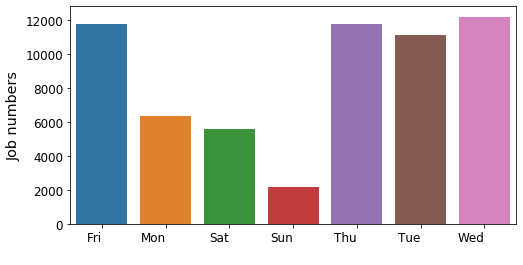

In [10]:
by_weekday = df_date_indeed.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday)
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Load Covid-19 Data

In [11]:
bydate_us = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/us_covid_19_data.csv')
bydate_us.head()

,Date,Confirmed,Deaths,Recovered,Active,New,Fatality
0,2020-01-22,1,0,0,1,0,0.0
1,2020-01-23,1,0,0,1,0,0.0
2,2020-01-24,2,0,0,2,1,0.0
3,2020-01-25,2,0,0,2,0,0.0
4,2020-01-26,5,0,0,5,3,0.0


In [12]:
bydate_us.set_index('Date', drop=True, inplace=True)
bydate_us['New']=bydate_us['New'].astype(np.float64)
bydate_us

,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,
2020-01-22,1,0,0,1,0.0,0.000000
2020-01-23,1,0,0,1,0.0,0.000000
2020-01-24,2,0,0,2,1.0,0.000000
2020-01-25,2,0,0,2,0.0,0.000000
2020-01-26,5,0,0,5,3.0,0.000000
...,...,...,...,...,...,...
2020-08-13,5248958,167110,1774648,3307200,51547.0,3.183680
2020-08-14,5313252,168452,1796326,3348474,64294.0,3.170412
2020-08-15,5361165,169481,1818527,3373157,47913.0,3.161272


In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Confirmed'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Deaths'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Recovered'], mode='lines', name='Recovered'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Active'], mode='lines', name='Active'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['New'], mode='lines', name='New'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Fatality'], mode='lines', name='Fatality Rate'))

fig.update_layout(title='US COVID-19 Cases')
fig.show()

## Combine Data

In [15]:
df_covid_trunc1 = bydate_us['2020-06-13':'2020-08-15']
df_indeed_trunc = df_date_indeed['2020-06-13':'2020-08-15']

df_combined_indeed = pd.concat([df_indeed_trunc, df_covid_trunc1], axis=1)
df_combined_indeed.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-06-13,2020-06-13,330,Sat,1,2074542,118093,556606,1399843,25556.0,5.692485
2020-06-14,2020-06-14,61,Sun,1,2094366,118401,561816,1414149,19824.0,5.653310
2020-06-15,2020-06-15,227,Mon,0,2114026,118792,576334,1418900,19660.0,5.619231
2020-06-16,2020-06-16,576,Tue,0,2137731,119635,583503,1434593,23705.0,5.596354
2020-06-17,2020-06-17,645,Wed,0,2163290,120387,592191,1450712,25559.0,5.564996


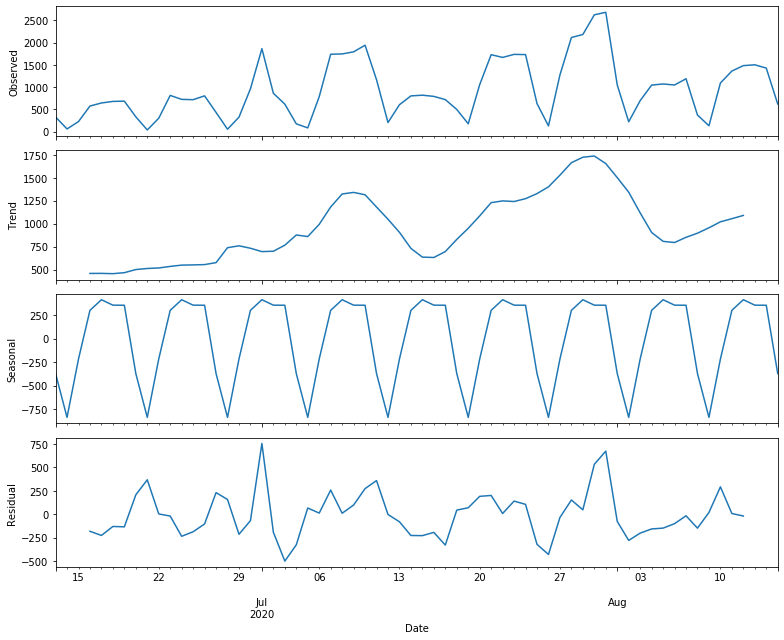

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

y=df_combined_indeed['Jobnums']
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Grid Search

In [17]:
def diff_transform(df_train,  d):
    """take difference"""
    df_diff = df_train.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            df_diff[str(col)+'_1d'] = df_diff[col].diff().fillna(0)
            df_diff.drop(columns=[col],inplace=True)
            if d>1:
                df_diff[str(col)+'_2d'] = df_diff[str(col)+'_1d'].diff().fillna(0)
                df_diff.drop(columns=[str(col)+'_1d'],inplace=True)
            
    return df_diff

In [18]:
def invert_transform(df_train, df_forecast, d):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            # Roll back 2nd Diff
            if d==2:
                df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
                df_fc.drop(columns=[str(col)+'_2d'],inplace=True)
            # Roll back 1st Diff
            df_fc[col] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
            df_fc.drop(columns=[str(col)+'_1d'],inplace=True)
    return df_fc

In [19]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def measure_rmse(actual, predicted):
    return rmse(actual, predicted)

def varmax_forecast(train, test_len, config, exog1=None, exog2=None):
    order, trend, d= config
    #d parameter to take difference
    df_diff = diff_transform(train,  d)
    try:
        model = VARMAX(df_diff, order=order, trend=trend, exog=exog1, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        yhat_diff = model_fit.forecast(steps=test_len, exog=exog2)
        yhat = invert_transform(train, yhat_diff, d)
    except:
        yhat = None
    return yhat

def single_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        yhat = varmax_forecast(train, len(test), cfg, exog1=exog_train, exog2=exog_test)
    else:
        yhat = varmax_forecast(train, len(test), cfg)
    if yhat is not None:
        error = measure_rmse(test['Jobnums'], yhat['Jobnums'])
    else:
        error = None
    return error

def walk_forward_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error

def score_model(data, n_test, cfg, method, exog=None, debug=True):
    result = None
    key = str(cfg)
    if debug:
        if method=='walk':
            result = walk_forward_validation(data, n_test, cfg, exog)
        else:
            result = single_validation(data, n_test, cfg, exog)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                if method=='walk':
                    result = walk_forward_validation(data, n_test, cfg, exog)
                else:
                    result = single_validation(data, n_test, cfg, exog)
        except:
            error = None
    if result is not None:
        print('---> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(data, cfg_list, n_test, method, exog=None, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, method, exog) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, method, exog) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def varmax_configs():
    models = list()
    p_params = [3, 4, 5, 6, 7, 8, 9, 10]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    d_params = [0, 1, 2]
    
    for p in p_params:
        for q in q_params:
            for t in t_params:
                for d in d_params:
                    cfg = [(p,q), t, d]
                    models.append(cfg)
    return models

In [20]:
def walk_forward_best(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error

#### No eXog + Walk

In [21]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=None, parallel=False)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 0]] 345.431
---> Model[[(3, 0), 'n', 1]] 338.502
---> Model[[(3, 0), 'n', 2]] 420.344
---> Model[[(3, 0), 'c', 0]] 343.934
---> Model[[(3, 0), 'c', 1]] 340.886
---> Model[[(3, 0), 'c', 2]] 436.021
---> Model[[(3, 0), 't', 0]] 500.040
---> Model[[(3, 0), 't', 1]] 347.497
---> Model[[(3, 0), 't', 2]] 442.699
---> Model[[(3, 0), 'ct', 0]] 401.048
---> Model[[(3, 0), 'ct', 1]] 336.736
---> Model[[(3, 0), 'ct', 2]] 448.365
---> Model[[(3, 1), 'n', 0]] 328.828
---> Model[[(3, 1), 'n', 1]] 247.647
---> Model[[(3, 1), 'n', 2]] 343.151
---> Model[[(3, 1), 'c', 0]] 276.543
---> Model[[(3, 1), 'c', 1]] 343.391
---> Model[[(3, 1), 'c', 2]] 434.120
---> Model[[(3, 1), 't', 0]] 712.345
---> Model[[(3, 1), 't', 1]] 285.046
---> Model[[(3, 1), 't', 2]] 472.156
---> Model[[(3, 1), 'ct', 0]] 495.815
---> Model[[(3, 1), 'ct', 1]] 391.885
---> Model[[(3, 1), 'ct', 2]] 532.221
---> Model[[(3, 2), 'n', 0]] 262.247
---> Model[[(3, 2), 'n', 1]] 286.894
---> Model[[(3, 2), 'n', 2]] 328

---> Model[[(9, 0), 'c', 1]] 308.959
---> Model[[(9, 0), 'c', 2]] 406.747
---> Model[[(9, 0), 't', 0]] 257.461
---> Model[[(9, 0), 't', 1]] 278.754
---> Model[[(9, 0), 't', 2]] 390.176
---> Model[[(9, 0), 'ct', 0]] 275.787
---> Model[[(9, 0), 'ct', 1]] 297.534
---> Model[[(9, 0), 'ct', 2]] 500.997
---> Model[[(9, 1), 'n', 0]] 333.166
---> Model[[(9, 1), 'n', 1]] 275.493
---> Model[[(9, 1), 'n', 2]] 343.387
---> Model[[(9, 1), 'c', 0]] 273.261
---> Model[[(9, 1), 'c', 1]] 291.161
---> Model[[(9, 1), 'c', 2]] 411.988
---> Model[[(9, 1), 't', 0]] 284.636
---> Model[[(9, 1), 't', 1]] 312.206
---> Model[[(9, 1), 't', 2]] 483.482
---> Model[[(9, 1), 'ct', 0]] 289.153
---> Model[[(9, 1), 'ct', 1]] 310.828
---> Model[[(9, 1), 'ct', 2]] 514.768
---> Model[[(9, 2), 'n', 0]] 374.029
---> Model[[(9, 2), 'n', 1]] 355.858
---> Model[[(9, 2), 'n', 2]] 318.292
---> Model[[(9, 2), 'c', 0]] 313.361
---> Model[[(9, 2), 'c', 1]] 354.030
---> Model[[(9, 2), 'c', 2]] 326.003
---> Model[[(9, 2), 't', 0]] 314

In [36]:
best_cfg = [(8, 0), 'c', 0]
n_test = 7
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_in_varma, error_in_varma = walk_forward_best(indeed_data, n_test, best_cfg)

#### X=weekend + Walk

In [22]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=df_combined_indeed[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 1]] 322.179
---> Model[[(3, 0), 'n', 0]] 279.027
---> Model[[(3, 0), 'n', 2]] 418.966
---> Model[[(3, 0), 'c', 0]] 195.910
---> Model[[(3, 0), 'c', 1]] 266.602
---> Model[[(3, 0), 'c', 2]] 396.649
---> Model[[(3, 0), 't', 0]] 294.837
---> Model[[(3, 0), 't', 1]] 283.823
---> Model[[(3, 0), 't', 2]] 408.295
---> Model[[(3, 0), 'ct', 0]] 280.982
---> Model[[(3, 0), 'ct', 1]] 303.545
---> Model[[(3, 0), 'ct', 2]] 441.459
---> Model[[(3, 1), 'n', 0]] 184.184
---> Model[[(3, 1), 'n', 2]] 322.136
---> Model[[(3, 1), 'n', 1]] 269.631
---> Model[[(3, 1), 'c', 0]] 195.744
---> Model[[(3, 1), 'c', 1]] 252.850
---> Model[[(3, 1), 'c', 2]] 312.100
---> Model[[(3, 1), 't', 0]] 266.585
---> Model[[(3, 1), 't', 1]] 235.760
---> Model[[(3, 1), 't', 2]] 314.396
---> Model[[(3, 1), 'ct', 0]] 279.241
---> Model[[(3, 1), 'ct', 1]] 269.921
---> Model[[(3, 1), 'ct', 2]] 326.747
---> Model[[(3, 2), 'n', 0]] 253.222
---> Model[[(3, 2), 'n', 1]] 251.813
---> Model[[(3, 2), 'n', 2]] 383

---> Model[[(9, 0), 'c', 1]] 209.241
---> Model[[(9, 0), 'c', 2]] 403.210
---> Model[[(9, 0), 't', 0]] 209.098
---> Model[[(9, 0), 't', 1]] 174.044
---> Model[[(9, 0), 't', 2]] 301.803
---> Model[[(9, 0), 'ct', 0]] 199.751
---> Model[[(9, 0), 'ct', 1]] 283.997
---> Model[[(9, 0), 'ct', 2]] 474.932
---> Model[[(9, 1), 'n', 0]] 323.580
---> Model[[(9, 1), 'n', 1]] 358.280
---> Model[[(9, 1), 'n', 2]] 277.255
---> Model[[(9, 1), 'c', 0]] 204.324
---> Model[[(9, 1), 'c', 1]] 138.335
---> Model[[(9, 1), 'c', 2]] 357.159
---> Model[[(9, 1), 't', 0]] 197.308
---> Model[[(9, 1), 't', 1]] 287.816
---> Model[[(9, 1), 't', 2]] 246.121
---> Model[[(9, 1), 'ct', 0]] 201.826
---> Model[[(9, 1), 'ct', 1]] 235.980
---> Model[[(9, 1), 'ct', 2]] 316.708
---> Model[[(9, 2), 'n', 0]] 258.444
---> Model[[(9, 2), 'n', 1]] 344.897
---> Model[[(9, 2), 'n', 2]] 324.713
---> Model[[(9, 2), 'c', 0]] 241.588
---> Model[[(9, 2), 'c', 1]] 262.990
---> Model[[(9, 2), 'c', 2]] 446.481
---> Model[[(9, 2), 't', 0]] 172

In [37]:
n_test = 7
best_cfg = [(7, 1), 'ct', 0]
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_in_varmax, error_in_varmax = walk_forward_best(indeed_data, n_test, best_cfg, exog=df_combined_indeed[['Weekend']])

In [38]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error_in_varma), 'X=Weekend, RMSE: {:0.2f}'.format(error_in_varmax)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_in_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_in_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='Indeed Software Engineer Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the Future

In [40]:
df_indeed_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_indeed_future['Date'] = pd.date_range('2020-08-16', '2020-08-22')
df_indeed_future.set_index('Date', inplace=True, drop=False)
df_indeed_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_indeed_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_indeed_future

,Date,Day of week,Weekend
Date,,,
2020-08-16,2020-08-16,Sun,1
2020-08-17,2020-08-17,Mon,0
2020-08-18,2020-08-18,Tue,0
2020-08-19,2020-08-19,Wed,0
2020-08-20,2020-08-20,Thu,0
2020-08-21,2020-08-21,Fri,0
2020-08-22,2020-08-22,Sat,1


In [41]:
n_test = 7
best_cfg = [(7, 1), 'ct', 0]
train = df_combined_indeed[['New','Jobnums']]
exog_train = df_combined_indeed[['Weekend']]
exog_test = df_indeed_future[['Weekend']]
indeed_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    indeed_pred = indeed_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [42]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_indeed_future.index[0],
            y0=0,
            x1=df_indeed_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_indeed.index, y=df_combined_indeed['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_indeed_future.index, y=indeed_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))
#fig.add_trace(go.Scatter(x=df_indeed_future.index, y=yhat_fcast['Jobnums'], mode='lines+markers', 
#                         marker=dict(size=8, color='green'), name='Future Forecast'))

# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,1],
#                          fill='tonexty',
#                          mode='lines', line_color='lightgrey',line_width=0,
#                          showlegend=False))
# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,0],
#                          fill='tonexty',
#                          mode='lines', line_color='grey', opacity=0.1, line_width=0,
#                          showlegend=False))

fig.add_annotation(
            x='2020-08-18',
            y=1600,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "Indeed Software Engineer Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

In [43]:
indeed_sde = pd.DataFrame(columns=['Source','Test_date','Yhat_varma','Yhat_varmax','Future_date','Forecast_varmax'])
indeed_sde['Source'] = 'Indeed_SDE'
indeed_sde['Test_date'] = test.index
indeed_sde['Yhat_varma'] = yhat_in_varma['Jobnums'].values
indeed_sde['Yhat_varmax'] = yhat_in_varmax['Jobnums'].values
indeed_sde['Future_date'] = df_indeed_future.index
indeed_sde['Forecast_varmax'] = indeed_pred['Jobnums'].values
indeed_sde.loc[:,'Source'] ='Indeed_SDE'
indeed_sde

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_SDE,2020-08-09,74.547267,170.939982,2020-08-16,339.779806
1,Indeed_SDE,2020-08-10,766.387521,1005.123513,2020-08-17,791.477745
2,Indeed_SDE,2020-08-11,1567.627976,1567.271388,2020-08-18,1300.681820
3,Indeed_SDE,2020-08-12,1437.516685,1507.419922,2020-08-19,1366.356807
4,Indeed_SDE,2020-08-13,1745.443564,1734.172933,2020-08-20,1634.163169
5,Indeed_SDE,2020-08-14,1298.334229,1491.354331,2020-08-21,1495.009032
6,Indeed_SDE,2020-08-15,534.683828,593.215423,2020-08-22,953.049078


# LinkedIn Data Modeling

## Load data

In [23]:
df_linkedin = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/linkedin_se_081620_combined.csv')
df_linkedin.head()

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Senior Software Engineer,Integrate,"Birmingham, Alabama, United States",2020-08-16,Mid-Senior level,Full-time,"Computer Software,Online Media,Marketing and A...","Integrate&nbsp;is a rapidly growing, venture-b...",Alabama,AL
1,Software Engineer - THAAD Foreign Military Sales,"Modern Technology Solutions, Inc. (MTSI)","Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Defense & Space,Aviation & Aerospace,Military","OverviewModern Technology Solutions, Inc. (MTS...",Alabama,AL
2,"Sr. Software Engineer - Ruby/Rails, Python or ...",CyberCoders,"Huntsville, Alabama, United States",2020-08-16,Mid-Senior level,Full-time,Internet,"-This role reports to Birmingham, AL-If you ar...",Alabama,AL
3,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
4,Software Engineer,Geeks and Nerds (GaN Corporation),"Auburn, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...","Geeks and Nerds, as an employee owned company,...",Alabama,AL


In [35]:
df_linkedin

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,Senior Software Engineer,Integrate,"Birmingham, Alabama, United States",2020-08-16,Mid-Senior level,Full-time,"Computer Software,Online Media,Marketing and A...","Integrate&nbsp;is a rapidly growing, venture-b...",Alabama,AL
1,Software Engineer - THAAD Foreign Military Sales,"Modern Technology Solutions, Inc. (MTSI)","Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Defense & Space,Aviation & Aerospace,Military","OverviewModern Technology Solutions, Inc. (MTS...",Alabama,AL
2,"Sr. Software Engineer - Ruby/Rails, Python or ...",CyberCoders,"Huntsville, Alabama, United States",2020-08-16,Mid-Senior level,Full-time,Internet,"-This role reports to Birmingham, AL-If you ar...",Alabama,AL
3,Big Data Developer with Security Clearance,ClearanceJobs,"Huntsville, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...",Please contact Matt at to discuss in further d...,Alabama,AL
4,Software Engineer,Geeks and Nerds (GaN Corporation),"Auburn, Alabama, United States",2020-08-16,Entry level,Full-time,"Information Technology and Services,Defense & ...","Geeks and Nerds, as an employee owned company,...",Alabama,AL
...,...,...,...,...,...,...,...,...,...,...
237168,C++ Embedded Software Engineer,Avesta Computer Services,"San Jose, California, United States",2020-07-22,Mid-Senior level,Contract,Information Technology and Services,Client:Our Client IS THE WORLDWIDE LEADER in n...,California,CA
237169,"Principal Software Engineer (Remote, Side Gig,...","Earbug, Inc.",San Francisco Bay Area,2020-07-17,NaN,NaN,NaN,NaN,California,CA
237170,Full Stack/Software Engineer,Populus Group,San Francisco Bay Area,2020-07-09,NaN,NaN,NaN,NaN,California,CA
237171,No C2C : No Sponsorship Offered : Job opportun...,DISYS,San Francisco Bay Area,2020-06-29,Mid-Senior level,Contract,"Banking,Investment Banking,Financial Services","This is a W2 Job, No C2C !!! Multiple FTE job...",California,CA


In [24]:
bydate = df_linkedin.groupby('Date').size()

df_date_linkedin = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})
df_date_linkedin['Date'] = pd.to_datetime(df_date_linkedin['Date'])
df_date_linkedin.set_index('Date', inplace=True, drop=False)

In [25]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_linkedin['Day of week'] = df_date_linkedin['Date'].apply(lambda x: week[x.weekday()])

In [26]:
df_date_linkedin['Weekend'] = df_date_linkedin['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)

In [27]:
df_date_linkedin_trunc = df_date_linkedin['2020-06-12':'2020-08-15']

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_linkedin_trunc.index, y=df_date_linkedin_trunc['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist(LinkedIn) open positions vs. post date')
fig.show()

Text(0.5, 0, ' ')

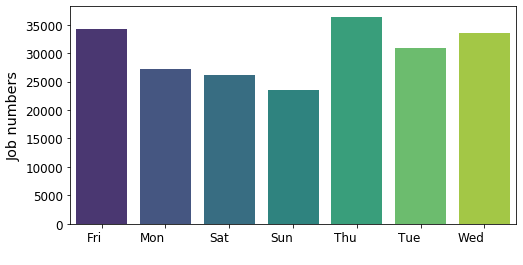

In [29]:
by_weekday = df_date_linkedin_trunc.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday, palette='viridis')
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Combine with COVID-19 

In [30]:
df_covid_trunc = bydate_us['2020-06-12':'2020-08-15']

df_combined_linkedin = pd.concat([df_date_linkedin_trunc, df_covid_trunc], axis=1)
df_combined_linkedin

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
Date,,,,,,,,,,
2020-06-12,2020-06-12,773,Fri,0,2048986,117330,547386,1384270,25330.0,5.726247
2020-06-13,2020-06-13,630,Sat,1,2074542,118093,556606,1399843,25556.0,5.692485
2020-06-14,2020-06-14,740,Sun,1,2094366,118401,561816,1414149,19824.0,5.653310
2020-06-15,2020-06-15,675,Mon,0,2114026,118792,576334,1418900,19660.0,5.619231
2020-06-16,2020-06-16,962,Tue,0,2137731,119635,583503,1434593,23705.0,5.596354
...,...,...,...,...,...,...,...,...,...,...
2020-08-11,2020-08-11,3633,Tue,0,5141208,164527,1714960,3261721,46808.0,3.200162
2020-08-12,2020-08-12,4252,Wed,0,5197411,166034,1753760,3277617,56203.0,3.194552
2020-08-13,2020-08-13,5754,Thu,0,5248958,167110,1774648,3307200,51547.0,3.183680


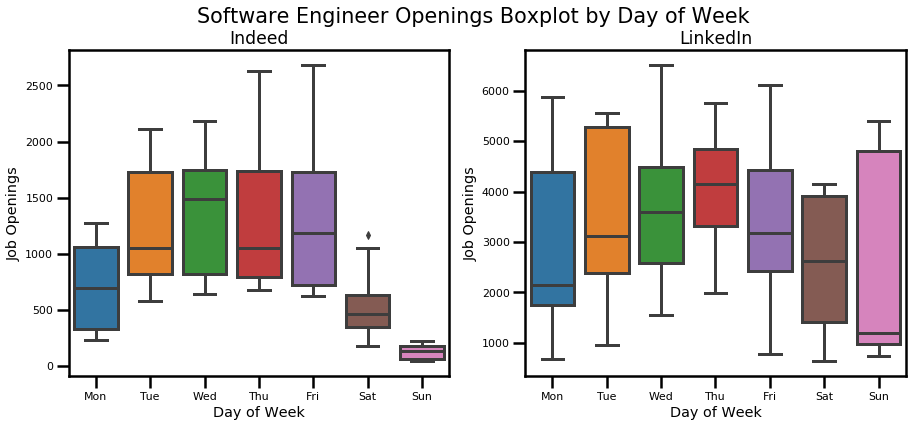

In [31]:
plt.figure(figsize=(15,6))
sns.set_context('poster',font_scale=0.5)
plt.subplot(121)
sns.boxplot(data=df_combined_indeed, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('Indeed', fontsize='x-large')
plt.subplot(122)
sns.boxplot(data=df_combined_linkedin, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('LinkedIn', fontsize='x-large')
plt.suptitle('Software Engineer Openings Boxplot by Day of Week', fontsize='xx-large')
plt.show()

## Grid Search

In [32]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'No eXog', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 2]] 1051.530
---> Model[[(3, 0), 'n', 1]] 983.336
---> Model[[(3, 0), 'c', 0]] 990.909
---> Model[[(3, 0), 'c', 1]] 999.844
---> Model[[(3, 0), 'c', 2]] 1062.139
---> Model[[(3, 0), 'n', 0]] 988.904
---> Model[[(3, 0), 't', 1]] 1007.870
---> Model[[(3, 0), 't', 0]] 998.720
---> Model[[(3, 0), 't', 2]] 1081.512
---> Model[[(3, 0), 'ct', 1]] 1026.926
---> Model[[(3, 0), 'ct', 0]] 1118.410
---> Model[[(3, 0), 'ct', 2]] 1080.434
---> Model[[(3, 1), 'n', 0]] 923.440
---> Model[[(3, 1), 'n', 1]] 777.566
---> Model[[(3, 1), 'n', 2]] 983.828
---> Model[[(3, 1), 'c', 0]] 1010.253
---> Model[[(3, 1), 'c', 1]] 977.317
---> Model[[(3, 1), 'c', 2]] 914.155
---> Model[[(3, 1), 't', 0]] 977.808
---> Model[[(3, 1), 't', 1]] 843.969
---> Model[[(3, 1), 't', 2]] 989.002
---> Model[[(3, 1), 'ct', 0]] 1006.161
---> Model[[(3, 1), 'ct', 1]] 1082.729
---> Model[[(3, 1), 'ct', 2]] 1179.027
---> Model[[(3, 2), 'n', 0]] 1004.088
---> Model[[(3, 2), 'n', 1]] 967.230
---> Model[[(3, 2), 

---> Model[[(9, 0), 'n', 2]] 1329.297
---> Model[[(9, 0), 'c', 0]] 1410.715
---> Model[[(9, 0), 'c', 1]] 1083.266
---> Model[[(9, 0), 'c', 2]] 1379.005
---> Model[[(9, 0), 't', 0]] 1052.484
---> Model[[(9, 0), 't', 1]] 1125.396
---> Model[[(9, 0), 't', 2]] 1485.035
---> Model[[(9, 0), 'ct', 0]] 1060.058
---> Model[[(9, 0), 'ct', 1]] 1130.536
---> Model[[(9, 0), 'ct', 2]] 1789.303
---> Model[[(9, 1), 'n', 0]] 1263.706
---> Model[[(9, 1), 'n', 1]] 1124.794
---> Model[[(9, 1), 'n', 2]] 1363.087
---> Model[[(9, 1), 'c', 0]] 1374.084
---> Model[[(9, 1), 'c', 1]] 1179.434
---> Model[[(9, 1), 'c', 2]] 1519.913
---> Model[[(9, 1), 't', 0]] 1052.210
---> Model[[(9, 1), 't', 1]] 1210.678
---> Model[[(9, 1), 't', 2]] 1630.466
---> Model[[(9, 1), 'ct', 0]] 1092.333
---> Model[[(9, 1), 'ct', 1]] 1105.101
---> Model[[(9, 1), 'ct', 2]] 1799.019
---> Model[[(9, 2), 'n', 0]] 1556.158
---> Model[[(9, 2), 'n', 1]] 1040.119
---> Model[[(9, 2), 'n', 2]] 1593.012
---> Model[[(9, 2), 'c', 0]] 1551.567
---> M

In [44]:
best_cfg = [(4, 0), 'c', 2]
n_test = 7
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_li_varma, error_li_varma = walk_forward_best(data, n_test, best_cfg)

### X=Weekend

In [33]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method,exog=df_combined_linkedin[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'X=weekend', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 1]] 1106.956
---> Model[[(3, 0), 'c', 0]] 1010.493
---> Model[[(3, 0), 'c', 1]] 1294.829
---> Model[[(3, 0), 'n', 0]] 984.121
---> Model[[(3, 0), 'n', 2]] 1079.605
---> Model[[(3, 0), 'c', 2]] 1036.344
---> Model[[(3, 0), 't', 1]] 1157.515
---> Model[[(3, 0), 't', 0]] 996.400
---> Model[[(3, 0), 't', 2]] 1068.134
---> Model[[(3, 0), 'ct', 0]] 1015.306
---> Model[[(3, 0), 'ct', 1]] 1441.729
---> Model[[(3, 0), 'ct', 2]] 1045.534
---> Model[[(3, 1), 'n', 0]] 1447.817
---> Model[[(3, 1), 'n', 1]] 1217.316
---> Model[[(3, 1), 'n', 2]] 660.172
---> Model[[(3, 1), 'c', 0]] 1018.167
---> Model[[(3, 1), 'c', 1]] 1411.268
---> Model[[(3, 1), 'c', 2]] 1360.238
---> Model[[(3, 1), 't', 0]] 1007.897
---> Model[[(3, 1), 't', 1]] 1401.753
---> Model[[(3, 1), 't', 2]] 812.308
---> Model[[(3, 1), 'ct', 0]] 1089.646
---> Model[[(3, 1), 'ct', 1]] 1310.696
---> Model[[(3, 1), 'ct', 2]] 1660.749
---> Model[[(3, 2), 'n', 0]] 1107.352
---> Model[[(3, 2), 'n', 1]] 1148.127
---> Model

---> Model[[(9, 0), 'n', 1]] 1059.235
---> Model[[(9, 0), 'n', 2]] 1440.584
---> Model[[(9, 0), 'c', 0]] 1463.486
---> Model[[(9, 0), 'c', 1]] 980.918
---> Model[[(9, 0), 'c', 2]] 1460.646
---> Model[[(9, 0), 't', 0]] 1236.781
---> Model[[(9, 0), 't', 1]] 1138.774
---> Model[[(9, 0), 't', 2]] 1264.119
---> Model[[(9, 0), 'ct', 0]] 1109.378
---> Model[[(9, 0), 'ct', 1]] 1171.097
---> Model[[(9, 0), 'ct', 2]] 2101.283
---> Model[[(9, 1), 'n', 0]] 2128.447
---> Model[[(9, 1), 'n', 1]] 1196.264
---> Model[[(9, 1), 'n', 2]] 1596.713
---> Model[[(9, 1), 'c', 0]] 1388.028
---> Model[[(9, 1), 'c', 1]] 1443.328
---> Model[[(9, 1), 'c', 2]] 1834.056
---> Model[[(9, 1), 't', 0]] 1346.766
---> Model[[(9, 1), 't', 1]] 1387.973
---> Model[[(9, 1), 't', 2]] 1421.611
---> Model[[(9, 1), 'ct', 0]] 1121.747
---> Model[[(9, 1), 'ct', 1]] 1352.379
---> Model[[(9, 1), 'ct', 2]] 2251.241
---> Model[[(9, 2), 'n', 0]] 1309.684
---> Model[[(9, 2), 'n', 1]] 1200.817
---> Model[[(9, 2), 'n', 2]] 1751.326
---> Mo

In [45]:
n_test = 7
best_cfg = [(5, 2), 'n', 2]
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_li_varmax, error_li_varmax = walk_forward_best(data, n_test, best_cfg, exog=df_combined_linkedin[['Weekend']])

In [46]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error_li_varma), 'X=Weekend, RMSE: {:0.2f}'.format(error_li_varmax)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_li_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_li_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='LinkedIn Software Engineer Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Future Forecast

In [48]:
df_linkedin_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_linkedin_future['Date'] = pd.date_range('2020-08-16', '2020-08-22')
df_linkedin_future.set_index('Date', inplace=True, drop=False)
df_linkedin_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_linkedin_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_linkedin_future

,Date,Day of week,Weekend
Date,,,
2020-08-16,2020-08-16,Sun,1
2020-08-17,2020-08-17,Mon,0
2020-08-18,2020-08-18,Tue,0
2020-08-19,2020-08-19,Wed,0
2020-08-20,2020-08-20,Thu,0
2020-08-21,2020-08-21,Fri,0
2020-08-22,2020-08-22,Sat,1


In [49]:
n_test = 7
best_cfg = [(5, 2), 'n', 2]
train = df_combined_linkedin[['New','Jobnums']]
exog_train = df_combined_linkedin[['Weekend']]
exog_test = df_linkedin_future[['Weekend']]
linkedin_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    linkedin_pred = linkedin_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [51]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_linkedin_future.index[0],
            y0=0,
            x1=df_linkedin_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_linkedin.index, y=df_combined_linkedin['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_linkedin_future.index, y=linkedin_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))


fig.add_annotation(
            x='2020-08-18',
            y=5120,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "LinkedIn Software Engineer Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

In [54]:
linkedin_sde = pd.DataFrame(columns=['Source','Test_date','Yhat_varma','Yhat_varmax','Future_date','Forecast_varmax'])
linkedin_sde['Source'] = 'LinkedIn_SDE'
linkedin_sde['Test_date'] = test.index
linkedin_sde['Yhat_varma'] = yhat_li_varma['Jobnums'].values
linkedin_sde['Yhat_varmax'] = yhat_li_varmax['Jobnums'].values
linkedin_sde['Future_date'] = df_linkedin_future.index
linkedin_sde['Forecast_varmax'] = linkedin_pred['Jobnums'].values
linkedin_sde.loc[:,'Source'] = 'LinkedIn_SDE'
linkedin_sde

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,LinkedIn_SDE,2020-08-09,4435.994632,4469.170871,2020-08-16,3261.315777
1,LinkedIn_SDE,2020-08-10,3946.676256,3896.600094,2020-08-17,4121.700788
2,LinkedIn_SDE,2020-08-11,3904.214453,4472.943030,2020-08-18,3238.333317
3,LinkedIn_SDE,2020-08-12,4244.078643,4318.414832,2020-08-19,5110.244266
4,LinkedIn_SDE,2020-08-13,4853.946385,5219.158473,2020-08-20,4241.701144
5,LinkedIn_SDE,2020-08-14,4565.695900,4289.091613,2020-08-21,4896.068814
6,LinkedIn_SDE,2020-08-15,4297.889100,4393.512352,2020-08-22,4243.552831


In [55]:
sde_combined = indeed_sde.append(linkedin_sde)
sde_combined

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_SDE,2020-08-09,74.547267,170.939982,2020-08-16,339.779806
1,Indeed_SDE,2020-08-10,766.387521,1005.123513,2020-08-17,791.477745
2,Indeed_SDE,2020-08-11,1567.627976,1567.271388,2020-08-18,1300.681820
3,Indeed_SDE,2020-08-12,1437.516685,1507.419922,2020-08-19,1366.356807
4,Indeed_SDE,2020-08-13,1745.443564,1734.172933,2020-08-20,1634.163169
5,Indeed_SDE,2020-08-14,1298.334229,1491.354331,2020-08-21,1495.009032
6,Indeed_SDE,2020-08-15,534.683828,593.215423,2020-08-22,953.049078
0,LinkedIn_SDE,2020-08-09,4435.994632,4469.170871,2020-08-16,3261.315777
1,LinkedIn_SDE,2020-08-10,3946.676256,3896.600094,2020-08-17,4121.700788
2,LinkedIn_SDE,2020-08-11,3904.214453,4472.943030,2020-08-18,3238.333317


In [56]:
sde_combined.to_csv('/Users/tingtingweng/Documents/summer_intern/data/var_sde_0815.csv',index=False)

In [57]:
ds_combined = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/var_ds_0815.csv')
ds_combined

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_DS,2020-08-09,20.980635,36.005440,2020-08-16,95.398523
1,Indeed_DS,2020-08-10,162.067301,150.091450,2020-08-17,161.567159
2,Indeed_DS,2020-08-11,187.303514,159.933595,2020-08-18,226.551819
3,Indeed_DS,2020-08-12,223.290504,215.837825,2020-08-19,185.225254
4,Indeed_DS,2020-08-13,179.088326,187.010141,2020-08-20,261.120855
5,Indeed_DS,2020-08-14,216.299127,236.907966,2020-08-21,200.189607
6,Indeed_DS,2020-08-15,91.928873,90.116349,2020-08-22,151.479609
7,LinkedIn_DS,2020-08-09,549.455028,605.865936,2020-08-16,413.877435
8,LinkedIn_DS,2020-08-10,449.458831,522.479883,2020-08-17,603.853651
9,LinkedIn_DS,2020-08-11,550.142644,586.518102,2020-08-18,598.374612


In [58]:
sde_combined = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/var_sde_0815.csv')
sde_combined

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_SDE,2020-08-09,74.547267,170.939982,2020-08-16,339.779806
1,Indeed_SDE,2020-08-10,766.387521,1005.123513,2020-08-17,791.477745
2,Indeed_SDE,2020-08-11,1567.627976,1567.271388,2020-08-18,1300.681820
3,Indeed_SDE,2020-08-12,1437.516685,1507.419922,2020-08-19,1366.356807
4,Indeed_SDE,2020-08-13,1745.443564,1734.172933,2020-08-20,1634.163169
5,Indeed_SDE,2020-08-14,1298.334229,1491.354331,2020-08-21,1495.009032
6,Indeed_SDE,2020-08-15,534.683828,593.215423,2020-08-22,953.049078
7,LinkedIn_SDE,2020-08-09,4435.994632,4469.170871,2020-08-16,3261.315777
8,LinkedIn_SDE,2020-08-10,3946.676256,3896.600094,2020-08-17,4121.700788
9,LinkedIn_SDE,2020-08-11,3904.214453,4472.943030,2020-08-18,3238.333317


In [59]:
tot_combined = ds_combined.append(sde_combined)
tot_combined

,Source,Test_date,Yhat_varma,Yhat_varmax,Future_date,Forecast_varmax
0,Indeed_DS,2020-08-09,20.980635,36.005440,2020-08-16,95.398523
1,Indeed_DS,2020-08-10,162.067301,150.091450,2020-08-17,161.567159
2,Indeed_DS,2020-08-11,187.303514,159.933595,2020-08-18,226.551819
3,Indeed_DS,2020-08-12,223.290504,215.837825,2020-08-19,185.225254
4,Indeed_DS,2020-08-13,179.088326,187.010141,2020-08-20,261.120855
5,Indeed_DS,2020-08-14,216.299127,236.907966,2020-08-21,200.189607
6,Indeed_DS,2020-08-15,91.928873,90.116349,2020-08-22,151.479609
7,LinkedIn_DS,2020-08-09,549.455028,605.865936,2020-08-16,413.877435
8,LinkedIn_DS,2020-08-10,449.458831,522.479883,2020-08-17,603.853651
9,LinkedIn_DS,2020-08-11,550.142644,586.518102,2020-08-18,598.374612


In [60]:
tot_combined.to_csv('/Users/tingtingweng/Documents/summer_intern/data/var_ds_sde_0815.csv',index=False)